In [1]:
from skfda import FDataGrid
from skfda.datasets import make_gaussian_process
from skfda.exploratory.visualization import SurfaceBoxplot, Boxplot

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# %%
# %%
import os
import sys
import numpy as np
# from torch.utils.data import TensorDataset, DataLoader

# DL-Kit
# sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/dl-kit') #TODO adjust path
# sys.path.append('/projects/ecrpstats/dl-kit') #TODO adjust path
# from dlkit.log.log_util import (logging_set_up, logging_get_logger)
# # from dlkit.nets.mlp import MLPModel
# from dlkit.opt.train import train_epochs
# from dlkit.nets.conv2d import Conv2dUpscaleModelInterpolate

## Load model module
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/paper_repo/auxilary_modules') #TODO adjust path
sys.path.append('/projects/ecrpstats/distributional_SRCNN/auxilary_modules')
import data_loading

import matplotlib.pyplot as plt

import pandas as pd


train_or_load = 'load'
# %%
hr_data_size = 64
lr_data_size = 8
# %%
epochs = 300
batch_size = 32
##
num_sing_mode = 50
##
region = 0
subregion = 'all'

log_file_base_path = 'parCov_fitting'

save_path = f'{log_file_base_path}.pt'

## ~~~~~~~~~~~
## import data
xtrainHR, xtestHR, xtrainLR, xtestLR = data_loading.import_data(
    region,
    subregion,
    train_fraction=.75, 
    order='(subregion, time)'
    )

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
xtestHR[0].shape

(1, 64, 64)

Define basis functions

In [5]:
N = 64
def compl_dft_basis(x, y, k_x, k_y):
    return np.exp(1j * 2*np.pi * (k_x*x + k_y*y)/N)

In [6]:
x = np.arange(0, N)

xg = np.tile(x, N)            # generates x-coordinates for the entire grid N*K 
yg = np.repeat(x, N, axis=0)

mat_xg = xg.reshape((64, 64))
mat_yg = yg.reshape((64, 64))

In [7]:
## Create basis functions to max period
# max_T = 20
# min_k = int(N/max_T)
min_k = 0
print(f"min k : {min_k}")
# max_k = (N)//2
max_k = (N)//2 + 1
print(f"max k : {max_k}")

basis_function_k_idx = []
basis_functions = []
for _kx in range(min_k, max_k):
    for _ky in range(min_k, max_k):
        basis_functions.append(
            compl_dft_basis(
                mat_xg, 
                mat_yg, 
                _kx, 
                _ky
                )
            )
        basis_function_k_idx.append((_kx, _ky))
        
basis_functions = np.asarray(basis_functions).reshape((-1, 64**2)).T / N
basis_functions.shape

min k : 0
max k : 33


(4096, 1089)

Generate noise rescaling

Load covariance parameters

In [9]:
## Compute global noise
global_cov_params = np.load("../stage_2/anal_sln_global_params.npy")

Sigma = np.matmul(
        np.matmul(
            basis_functions, 
            np.diag(global_cov_params)
            ),
        np.conj(basis_functions.T)
        )

u, s, vh = np.linalg.svd(np.real(Sigma))

Z = np.random.randn(100, hr_data_size**2)
rescaled_noise = Z @ np.diag(s**0.5) @ u.T

Load global model 

In [10]:
path_to_global_err_fields = "../stage_3/output_data/fcov_GL_mseStart_global_errFields.npy"
global_err_fields = np.load(path_to_global_err_fields)
global_err_fields.shape

targets = xtestHR.squeeze()

global_pred = global_err_fields + targets

def global_samples_for_plot(img_idx):
    _img_samples = rescaled_noise + global_pred[img_idx].ravel()[None, :]
    _out = _img_samples.reshape((-1, hr_data_size, hr_data_size))
    return _out


In [11]:
_for_plot = global_samples_for_plot(4)

In [12]:

from skfda import FDataGrid


In [13]:
from skfda.exploratory.visualization import Boxplot


Text(85.45833333333331, 0.5, 'Pixel Value')

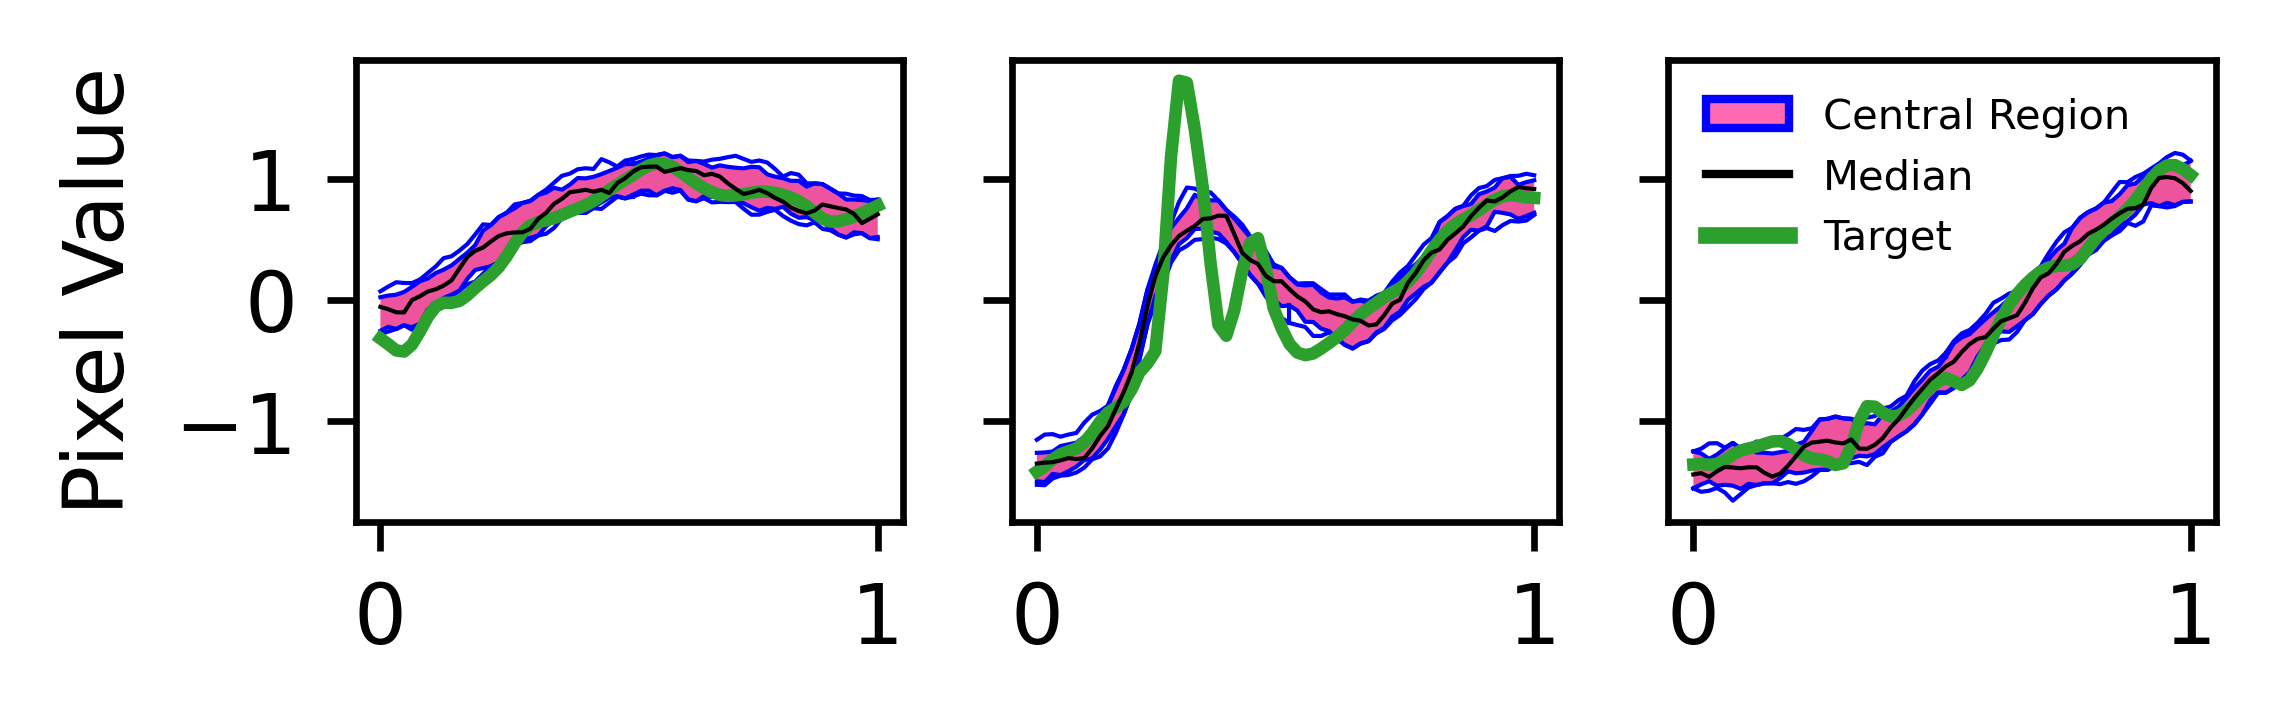

In [69]:
fig, axs = plt.subplots(1, 3, dpi=600, figsize=(4, 1), sharey=True)
# fig, axs = plt.subplots(3, 1, dpi=600, figsize=(4, 8), sharey=True, sharex=True)

_img_idx = 4
_img_samples = global_samples_for_plot(_img_idx)

sliced_fd_0 = FDataGrid(_img_samples[:, 0, :])
boxplot = Boxplot(sliced_fd_0, axes=axs[0])
boxplot.plot()

sliced_fd_1 = FDataGrid(_img_samples[:, 31, :])
boxplot = Boxplot(sliced_fd_1, axes=axs[1])
boxplot.plot()

sliced_fd_2 = FDataGrid(_img_samples[:, 63, :])
boxplot = Boxplot(sliced_fd_2, axes=axs[2])
boxplot.plot()

for ax in axs:
    for line in ax.get_lines():
        line.set_linewidth(.5)  # set your desired linewidth

fig.canvas.draw()  # update the figure if you're in an interactive session

axs[0].plot(np.linspace(0, 1, 64), targets[_img_idx, 0, :], color='C2', zorder=4)
axs[1].plot(np.linspace(0, 1, 64), targets[_img_idx, 31, :], color='C2', zorder=4)
axs[2].plot(np.linspace(0, 1, 64), targets[_img_idx, 63, :], color='C2', zorder=4, label='target')

## ~~~ Legend ~~~
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Then manually create a custom legend
custom_handles = [
    Patch(facecolor='#ff69b4', edgecolor='blue', label='Central Region'),
    Line2D([], [], color='black', linewidth=1, label='Median'),
    Line2D([0], [0], color='C2', linewidth=2, label='Target'),
]

axs[2].legend(handles=custom_handles, loc='upper left', fontsize=5, frameon=False)
axs[0].set_ylabel('Pixel Value')

# for i, ax in enumerate(axs):
#     ax.set_xlabel()



Text(0.5, 1.3, 'Global Covariance')

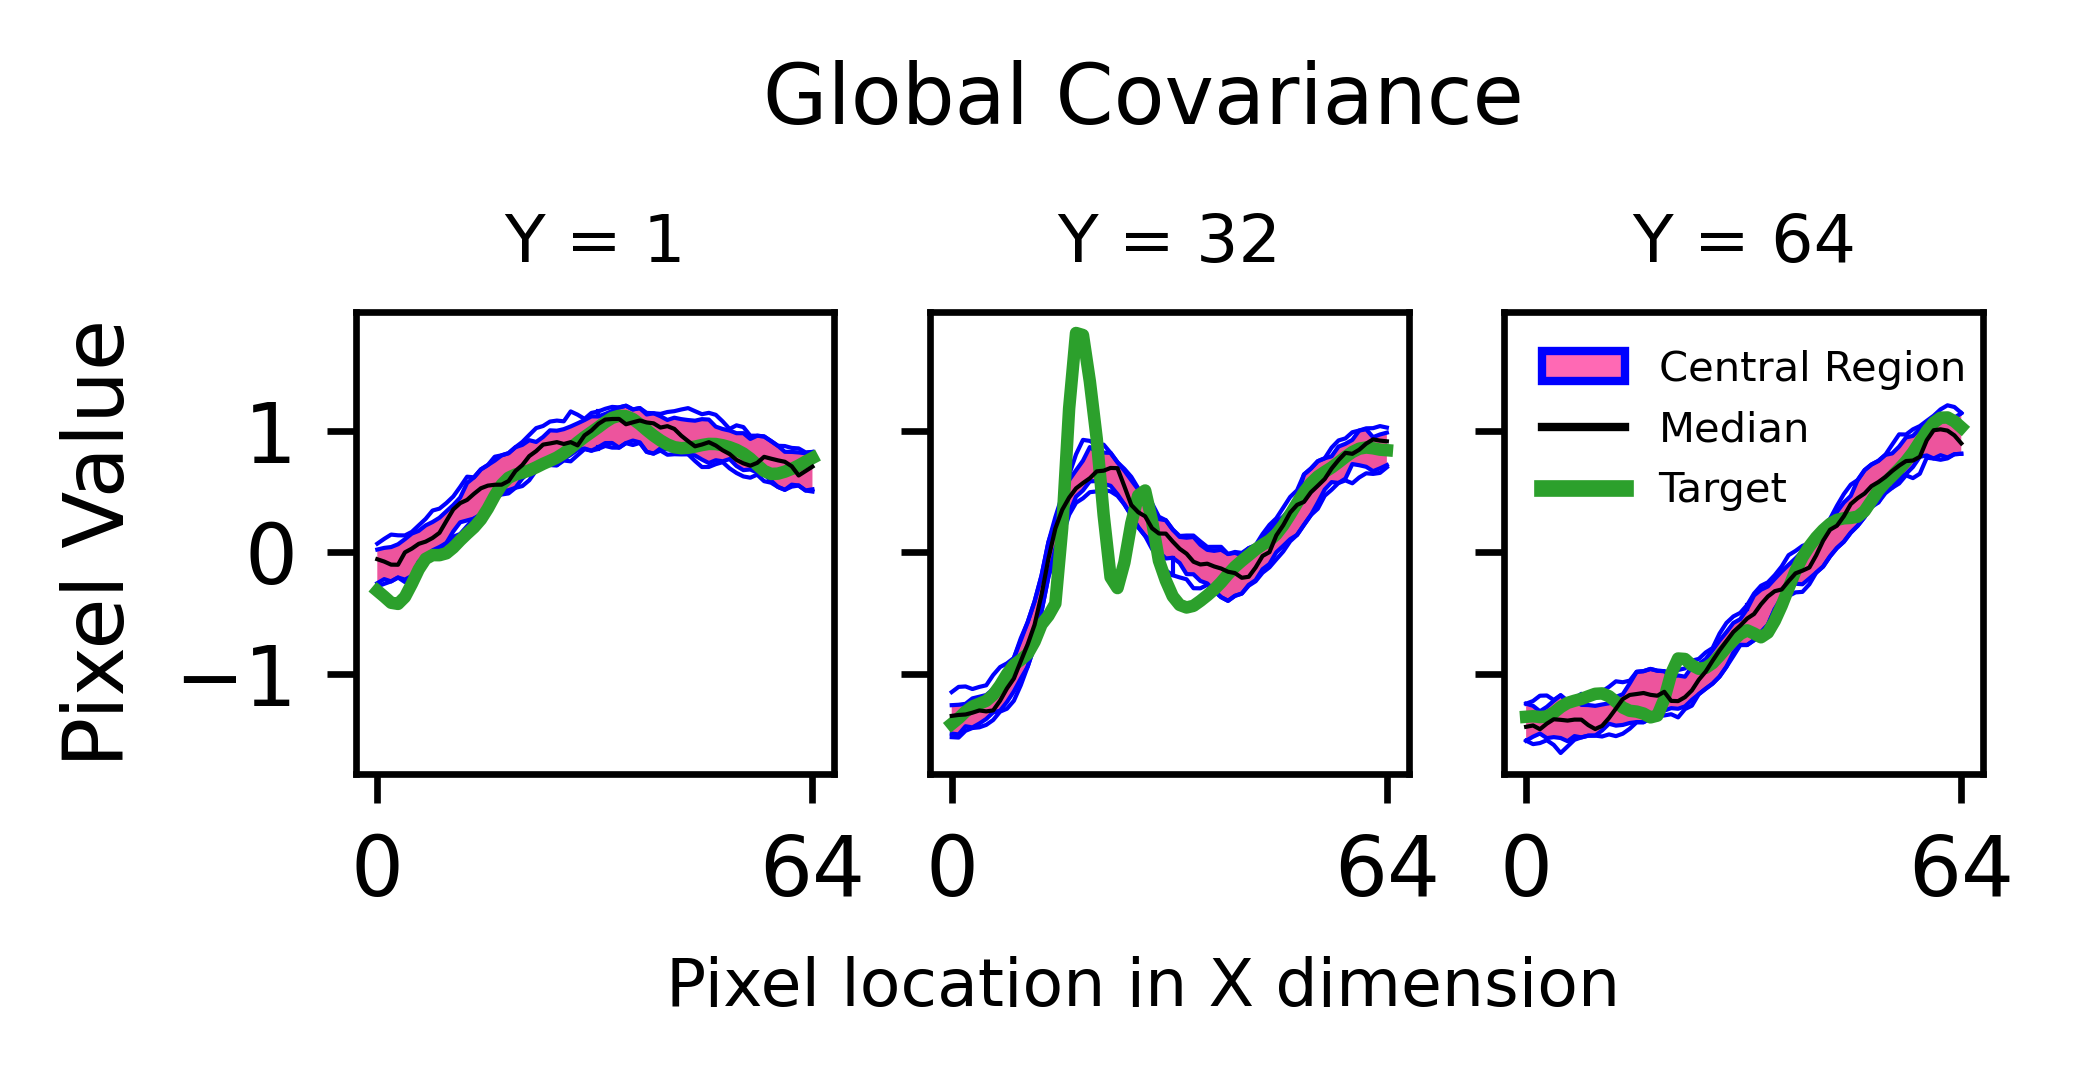

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(1, 3, dpi=600, figsize=(3.5, 1), sharey=True)

_img_idx = 4
_img_samples = global_samples_for_plot(_img_idx)

sliced_fd_0 = FDataGrid(_img_samples[:, 0, :])
Boxplot(sliced_fd_0, axes=axs[0]).plot()

sliced_fd_1 = FDataGrid(_img_samples[:, 31, :])
Boxplot(sliced_fd_1, axes=axs[1]).plot()

sliced_fd_2 = FDataGrid(_img_samples[:, 63, :])
Boxplot(sliced_fd_2, axes=axs[2]).plot()

for ax in axs:
    for line in ax.get_lines():
        line.set_linewidth(0.5)
    # Set x-ticks from 0 to 64
    ax.set_xticks(np.linspace(0, 1, 2))  # 9 evenly spaced ticks (0 to 64 in steps of 8)
    ax.set_xticklabels(np.linspace(0, 64, 2, dtype=int))  # Labels 0 through 64

fig.canvas.draw()

axs[0].plot(np.linspace(0, 1, 64), targets[_img_idx, 0, :], color='C2', zorder=4)
axs[1].plot(np.linspace(0, 1, 64), targets[_img_idx, 31, :], color='C2', zorder=4)
axs[2].plot(np.linspace(0, 1, 64), targets[_img_idx, 63, :], color='C2', zorder=4, label='target')

## Legend 
custom_handles = [
    Patch(facecolor='#ff69b4', edgecolor='blue', label='Central Region'),
    Line2D([], [], color='black', linewidth=1, label='Median'),
    Line2D([0], [0], color='C2', linewidth=2, label='Target'),
]

axs[2].legend(handles=custom_handles, loc='upper left', fontsize=5, frameon=False)

# Y-axis label
axs[0].set_ylabel('Pixel Value')

# Subplot titles
axs[0].set_title('Y = 1', fontsize=8)
axs[1].set_title('Y = 32', fontsize=8)
axs[2].set_title('Y = 64', fontsize=8)

# Shared x-axis label
fig.supxlabel('Pixel location in X dimension', fontsize=8,  y=-0.3)

# Shared figure title
fig.suptitle('Global Covariance', fontsize=10, y=1.3)

# Adjust layout to prevent overlap
# fig.tight_layout()


# img-specific model

In [46]:
def get_noise_from_cov_params_wSVD(cov_params, n_samples=10):

    Sigma = np.matmul(
        np.matmul(
            basis_functions, 
            np.diag(cov_params)
            ),
        np.conj(basis_functions.T)
        )
    
    u, s, vh = np.linalg.svd(np.real(Sigma))
    
    Z = np.random.randn(n_samples, hr_data_size**2)
    
    rescaled_noise = Z @ np.diag(s**0.5) @ u.T
    
    return rescaled_noise

In [47]:
## analytic results with correct downscaling
p5p5_cov_params = np.load(
    "../stage_2/output/parCov_fitting_fourier_allImages_mseStart_globalPrior_anal_empPriorStdOn5p5_param_fits.npy"
    )

p5p5_err = np.load(
    "../stage_3/output_data/fcov_GL_mseStart_gPAStdOn5p5_errFields.npy")

In [48]:
p5p5_pred = p5p5_err + targets

In [49]:
p5p5_pred.shape

(214, 64, 64)

In [50]:
p5p5_cov_params.shape

(856, 1089)

In [51]:
test_p5p5_cov_params = p5p5_cov_params[-214:]
test_p5p5_cov_params.shape

(214, 1089)

In [52]:
p5p5_img_4_noise = get_noise_from_cov_params_wSVD(test_p5p5_cov_params[4], n_samples=100)
# p5p5_img_100_noise = get_noise_from_cov_params_wSVD(test_p5p5_cov_params[100], n_samples=100)
# p5p5_img_200_noise = get_noise_from_cov_params_wSVD(test_p5p5_cov_params[200], n_samples=100)


In [53]:
p5p5_img_4_noise.shape

(100, 4096)

In [54]:
np.save('p5p5_img_4_noise.npy', p5p5_img_4_noise)
# np.save('sample_data/p2p5_img_100_noise.npy', p2p5_img_100_noise)
# np.save('sample_data/p2p5_img_200_noise.npy', p2p5_img_200_noise)

In [55]:
def p5p5_samples_for_plot(img, noise):
    _img_samples = noise + img.ravel()[None, :]
    _out = _img_samples.reshape((-1, hr_data_size, hr_data_size))
    return _out

In [56]:
p5p5_img4_samples = p5p5_samples_for_plot(p5p5_pred[4], p5p5_img_4_noise)

Text(0.5, 1.3, 'Image-Specific Covariance')

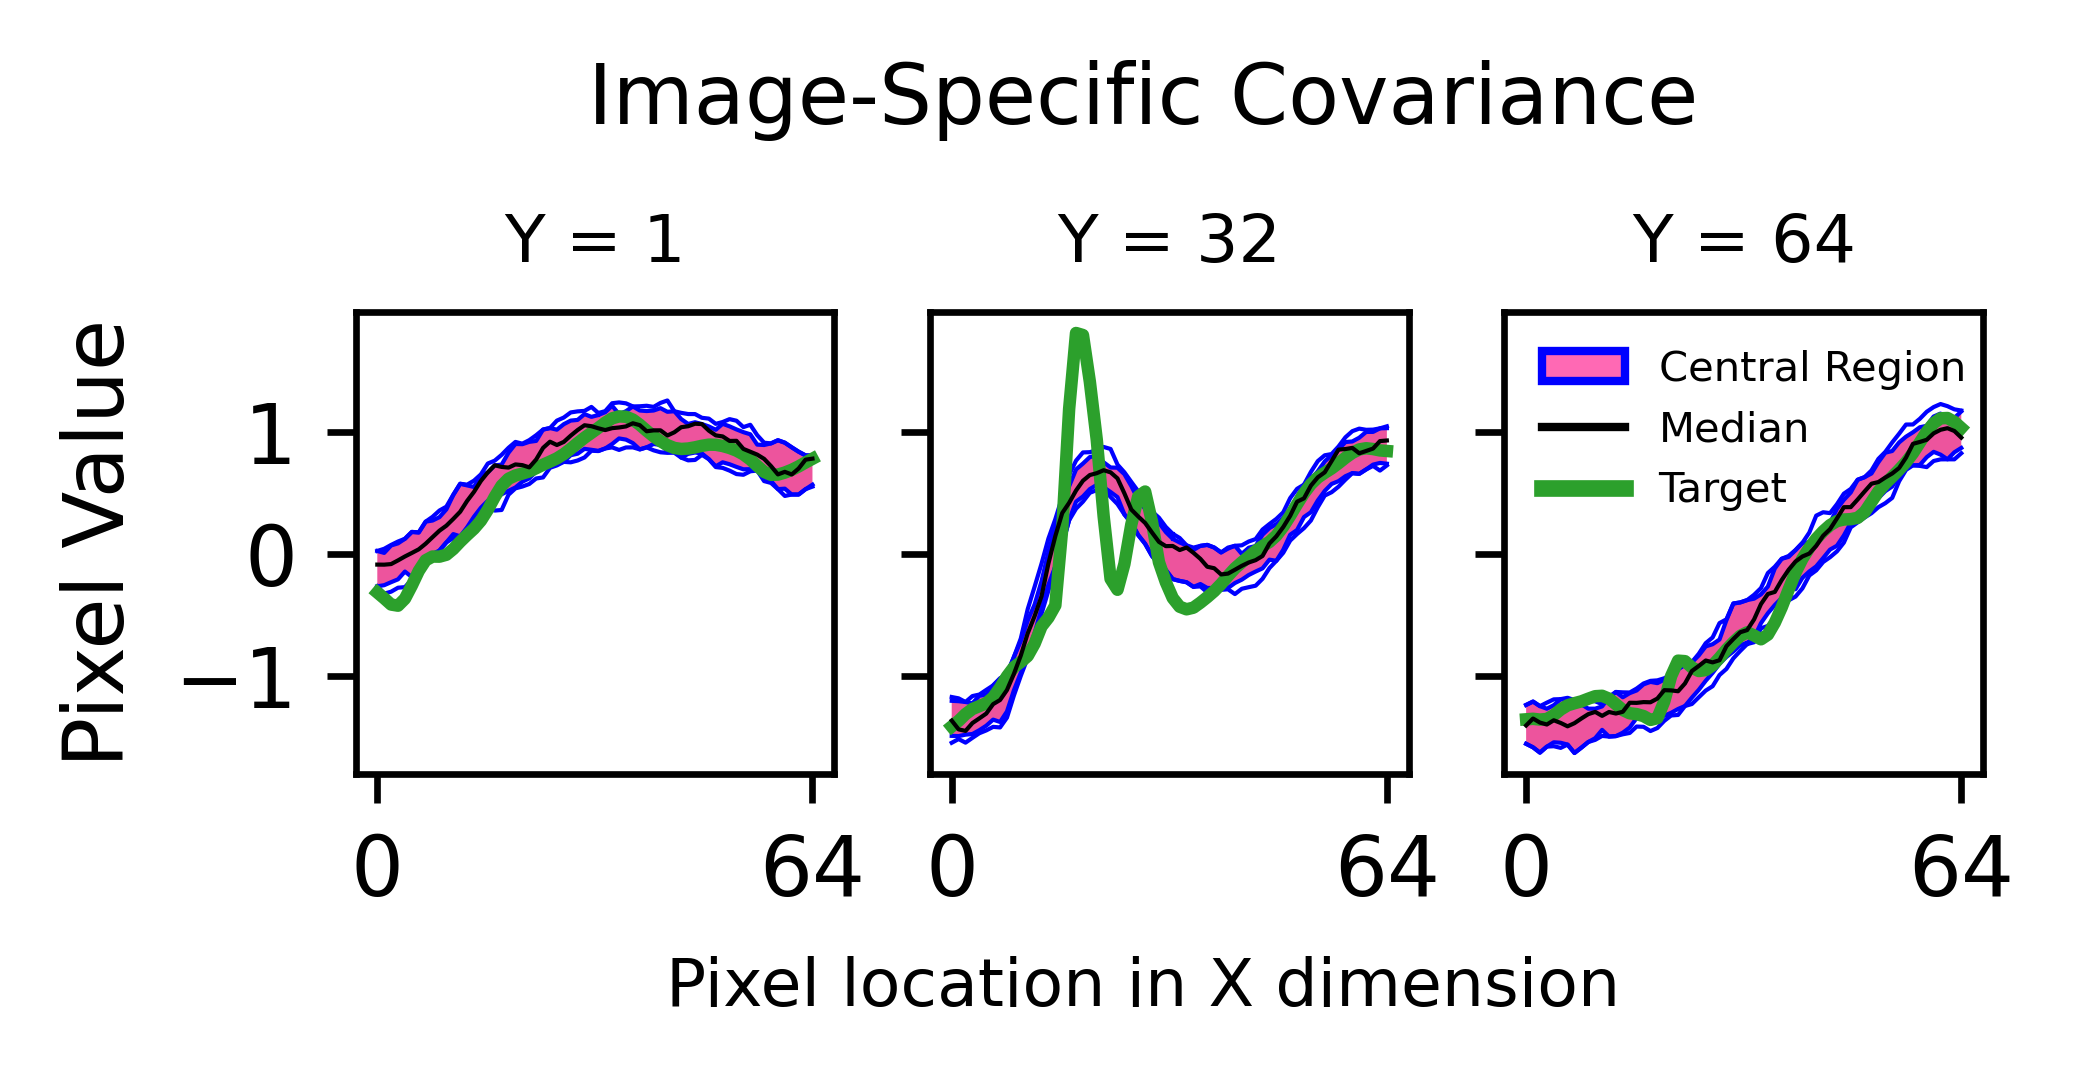

In [70]:

fig, axs = plt.subplots(1, 3, dpi=600, figsize=(3.5, 1), sharey=True)
# fig, axs = plt.subplots(3, 1, dpi=600, figsize=(4, 8), sharey=True, sharex=True)

_img_idx = 4
_img_samples = p5p5_img4_samples

sliced_fd_0 = FDataGrid(_img_samples[:, 0, :])
Boxplot(sliced_fd_0, axes=axs[0]).plot()

sliced_fd_1 = FDataGrid(_img_samples[:, 31, :])
Boxplot(sliced_fd_1, axes=axs[1]).plot()

sliced_fd_2 = FDataGrid(_img_samples[:, 63, :])
Boxplot(sliced_fd_2, axes=axs[2]).plot()

for ax in axs:
    for line in ax.get_lines():
        line.set_linewidth(0.5)
    # Set x-ticks from 0 to 64
    ax.set_xticks(np.linspace(0, 1, 2))  # 9 evenly spaced ticks (0 to 64 in steps of 8)
    ax.set_xticklabels(np.linspace(0, 64, 2, dtype=int))  # Labels 0 through 64

fig.canvas.draw()

axs[0].plot(np.linspace(0, 1, 64), targets[_img_idx, 0, :], color='C2', zorder=4)
axs[1].plot(np.linspace(0, 1, 64), targets[_img_idx, 31, :], color='C2', zorder=4)
axs[2].plot(np.linspace(0, 1, 64), targets[_img_idx, 63, :], color='C2', zorder=4, label='target')

## Legend 
custom_handles = [
    Patch(facecolor='#ff69b4', edgecolor='blue', label='Central Region'),
    Line2D([], [], color='black', linewidth=1, label='Median'),
    Line2D([0], [0], color='C2', linewidth=2, label='Target'),
]

axs[2].legend(handles=custom_handles, loc='upper left', fontsize=5, frameon=False)

# Y-axis label
axs[0].set_ylabel('Pixel Value')

# Subplot titles
axs[0].set_title('Y = 1', fontsize=8)
axs[1].set_title('Y = 32', fontsize=8)
axs[2].set_title('Y = 64', fontsize=8)

# Shared x-axis label
fig.supxlabel('Pixel location in X dimension', fontsize=8,  y=-0.3)

# Shared figure title
fig.suptitle('Image-Specific Covariance', fontsize=10, y=1.3)

# Adjust layout to prevent overlap
# fig.tight_layout()


Quantify containment within surface boxplot

In [142]:
fd = FDataGrid(p5p5_img4_samples)

surfaceBoxplot = SurfaceBoxplot(fd)
# envelope = surfaceBoxplot.central_envelope_

In [143]:
from skfda.exploratory.depth import ModifiedBandDepth

# Create the depth object
depth = ModifiedBandDepth()

# Evaluate depths on the dataset
depths = depth(fd)

In [144]:
# Get index of the deepest (median) surface
median_idx = np.argmax(depths)
median_surface = fd[median_idx].data_matrix.squeeze()

# Get central region (e.g., 50% deepest)
n = len(fd)
central_region_indices = np.argsort(-depths)[:n // 2]
central_region = fd[central_region_indices]

In [145]:
surfaces = central_region.data_matrix
lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
upper_surface = np.max(surfaces, axis=0)


In [146]:
lower_surface.shape

(64, 64, 1)

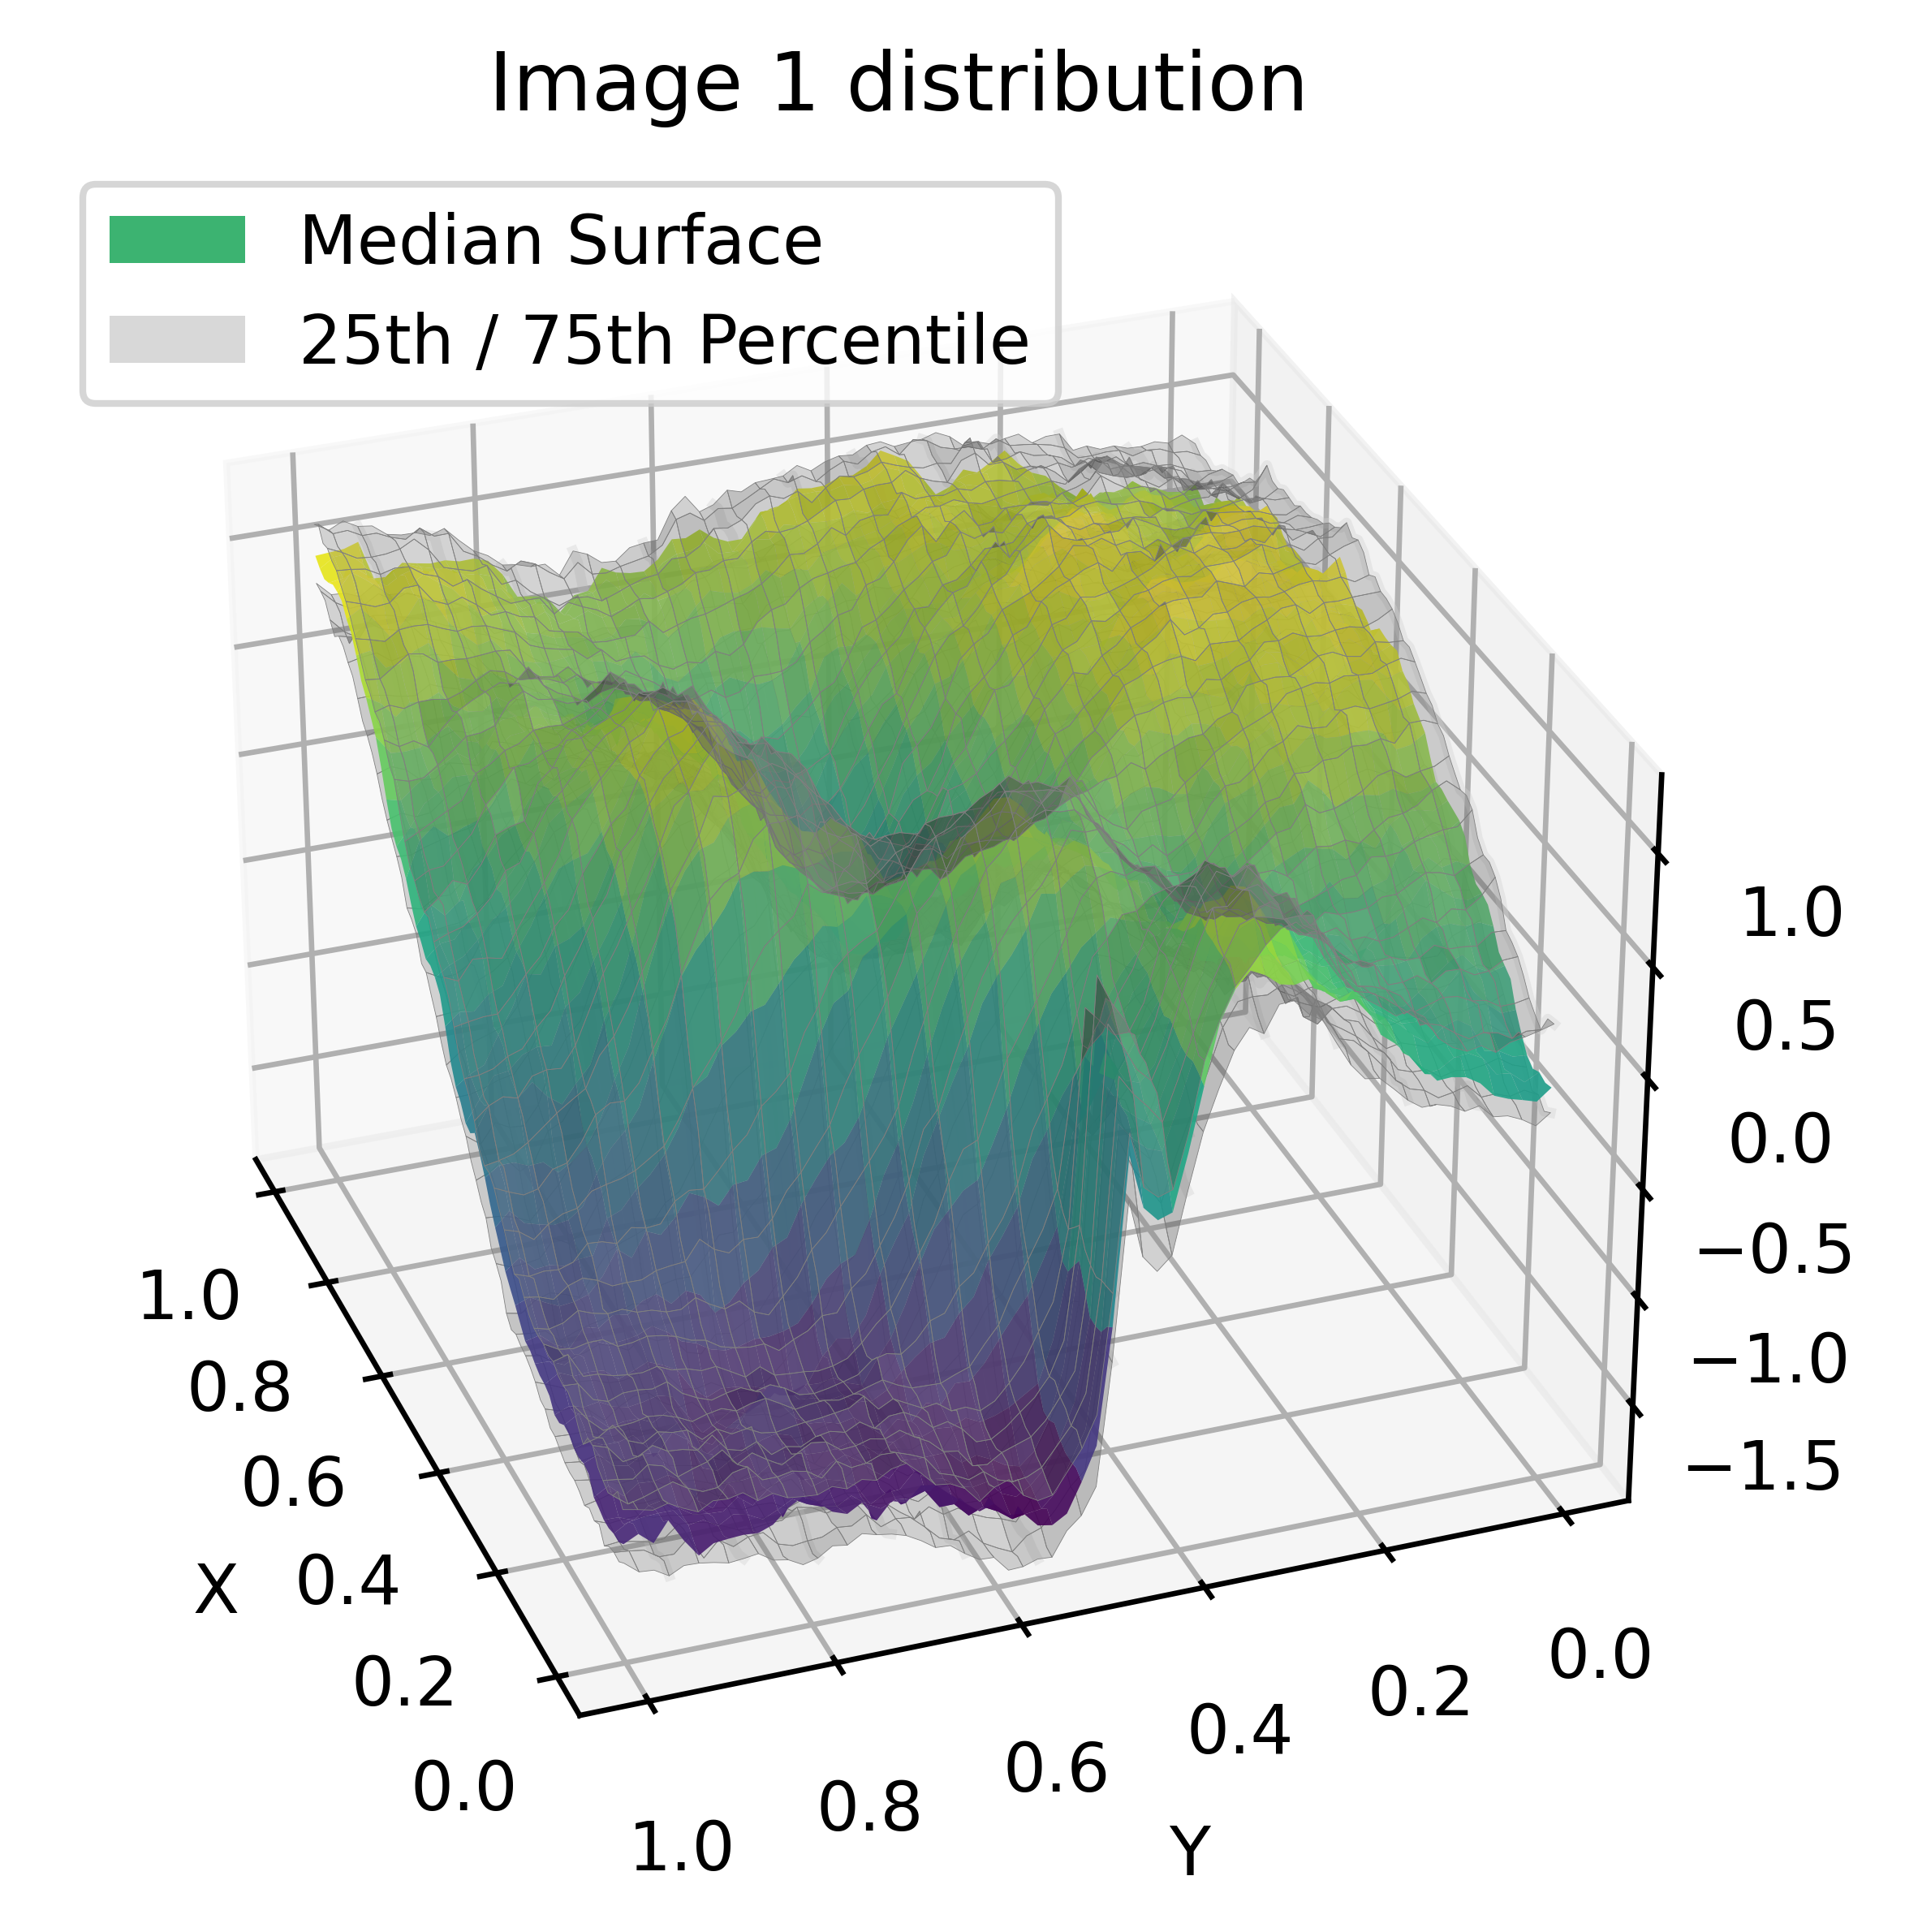

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulated data: 100 surfaces over a 50x50 grid
n_samples = 100
nx, ny = 64, 64
surfaces = np.random.randn(n_samples, nx, ny)  # shape (n, nx, ny)

# X, Y grid
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

# Compute quantiles
# median_surface = median_surface.data_matrix.squeeze()
q75 = upper_surface.squeeze()
q25 = lower_surface.squeeze()

# Plot
fig = plt.figure(figsize=(6, 4), dpi=600)
ax = fig.add_subplot(111, projection='3d')

# Plot median surface
ax.plot_surface(X, Y, median_surface, cmap='viridis', alpha=0.9, label='Median')

# Plot 25th percentile surface
ax.plot_surface(
    X, Y, q75, color='gray', 
    edgecolor='grey', 
    linewidth=.1,
    # edgealpha=.3,
    alpha=0.3
    )

# Plot 75th percentile surface
ax.plot_surface(
    X, 
    Y, 
    q25, 
    color='gray', 
    edgecolor='grey', 
    linewidth=.1,
    alpha=0.3)

# Optional: fill between surfaces using lines
for i in range(0, nx, 5):  # less dense lines for clarity
    ax.plot(X[i], Y[i], q25[i], color='lightgray', alpha=0.4)
    ax.plot(X[i], Y[i], q75[i], color='lightgray', alpha=0.4)

ax.set_title("Image 1 distribution")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='mediumseagreen', label='Median Surface'),
    Patch(facecolor='gray', alpha=0.3, label='25th / 75th Percentile')
]

ax.legend(handles=legend_elements, loc='upper left')

# ax.view_init(elev=15, azim=-100)   # shallow angle, from front-left
ax.view_init(azim=160)    # top-down



plt.tight_layout()
plt.show()


Global

In [177]:
# fd_g = FDataGrid(img_0_samples.reshape((-1, hr_data_size, hr_data_size)))
fd_g = FDataGrid(global_samples_for_plot(4))


In [178]:
# Evaluate depths on the dataset
depths = depth(fd_g)

In [179]:
# Get index of the deepest (median) surface
median_idx = np.argmax(depths)
median_surface = fd_g[median_idx].data_matrix.squeeze()

# Get central region (e.g., 50% deepest)
n = len(fd_g)
central_region_indices = np.argsort(-depths)[:n // 2]
central_region = fd_g[central_region_indices]

In [180]:
surfaces = central_region.data_matrix
lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
upper_surface = np.max(surfaces, axis=0)


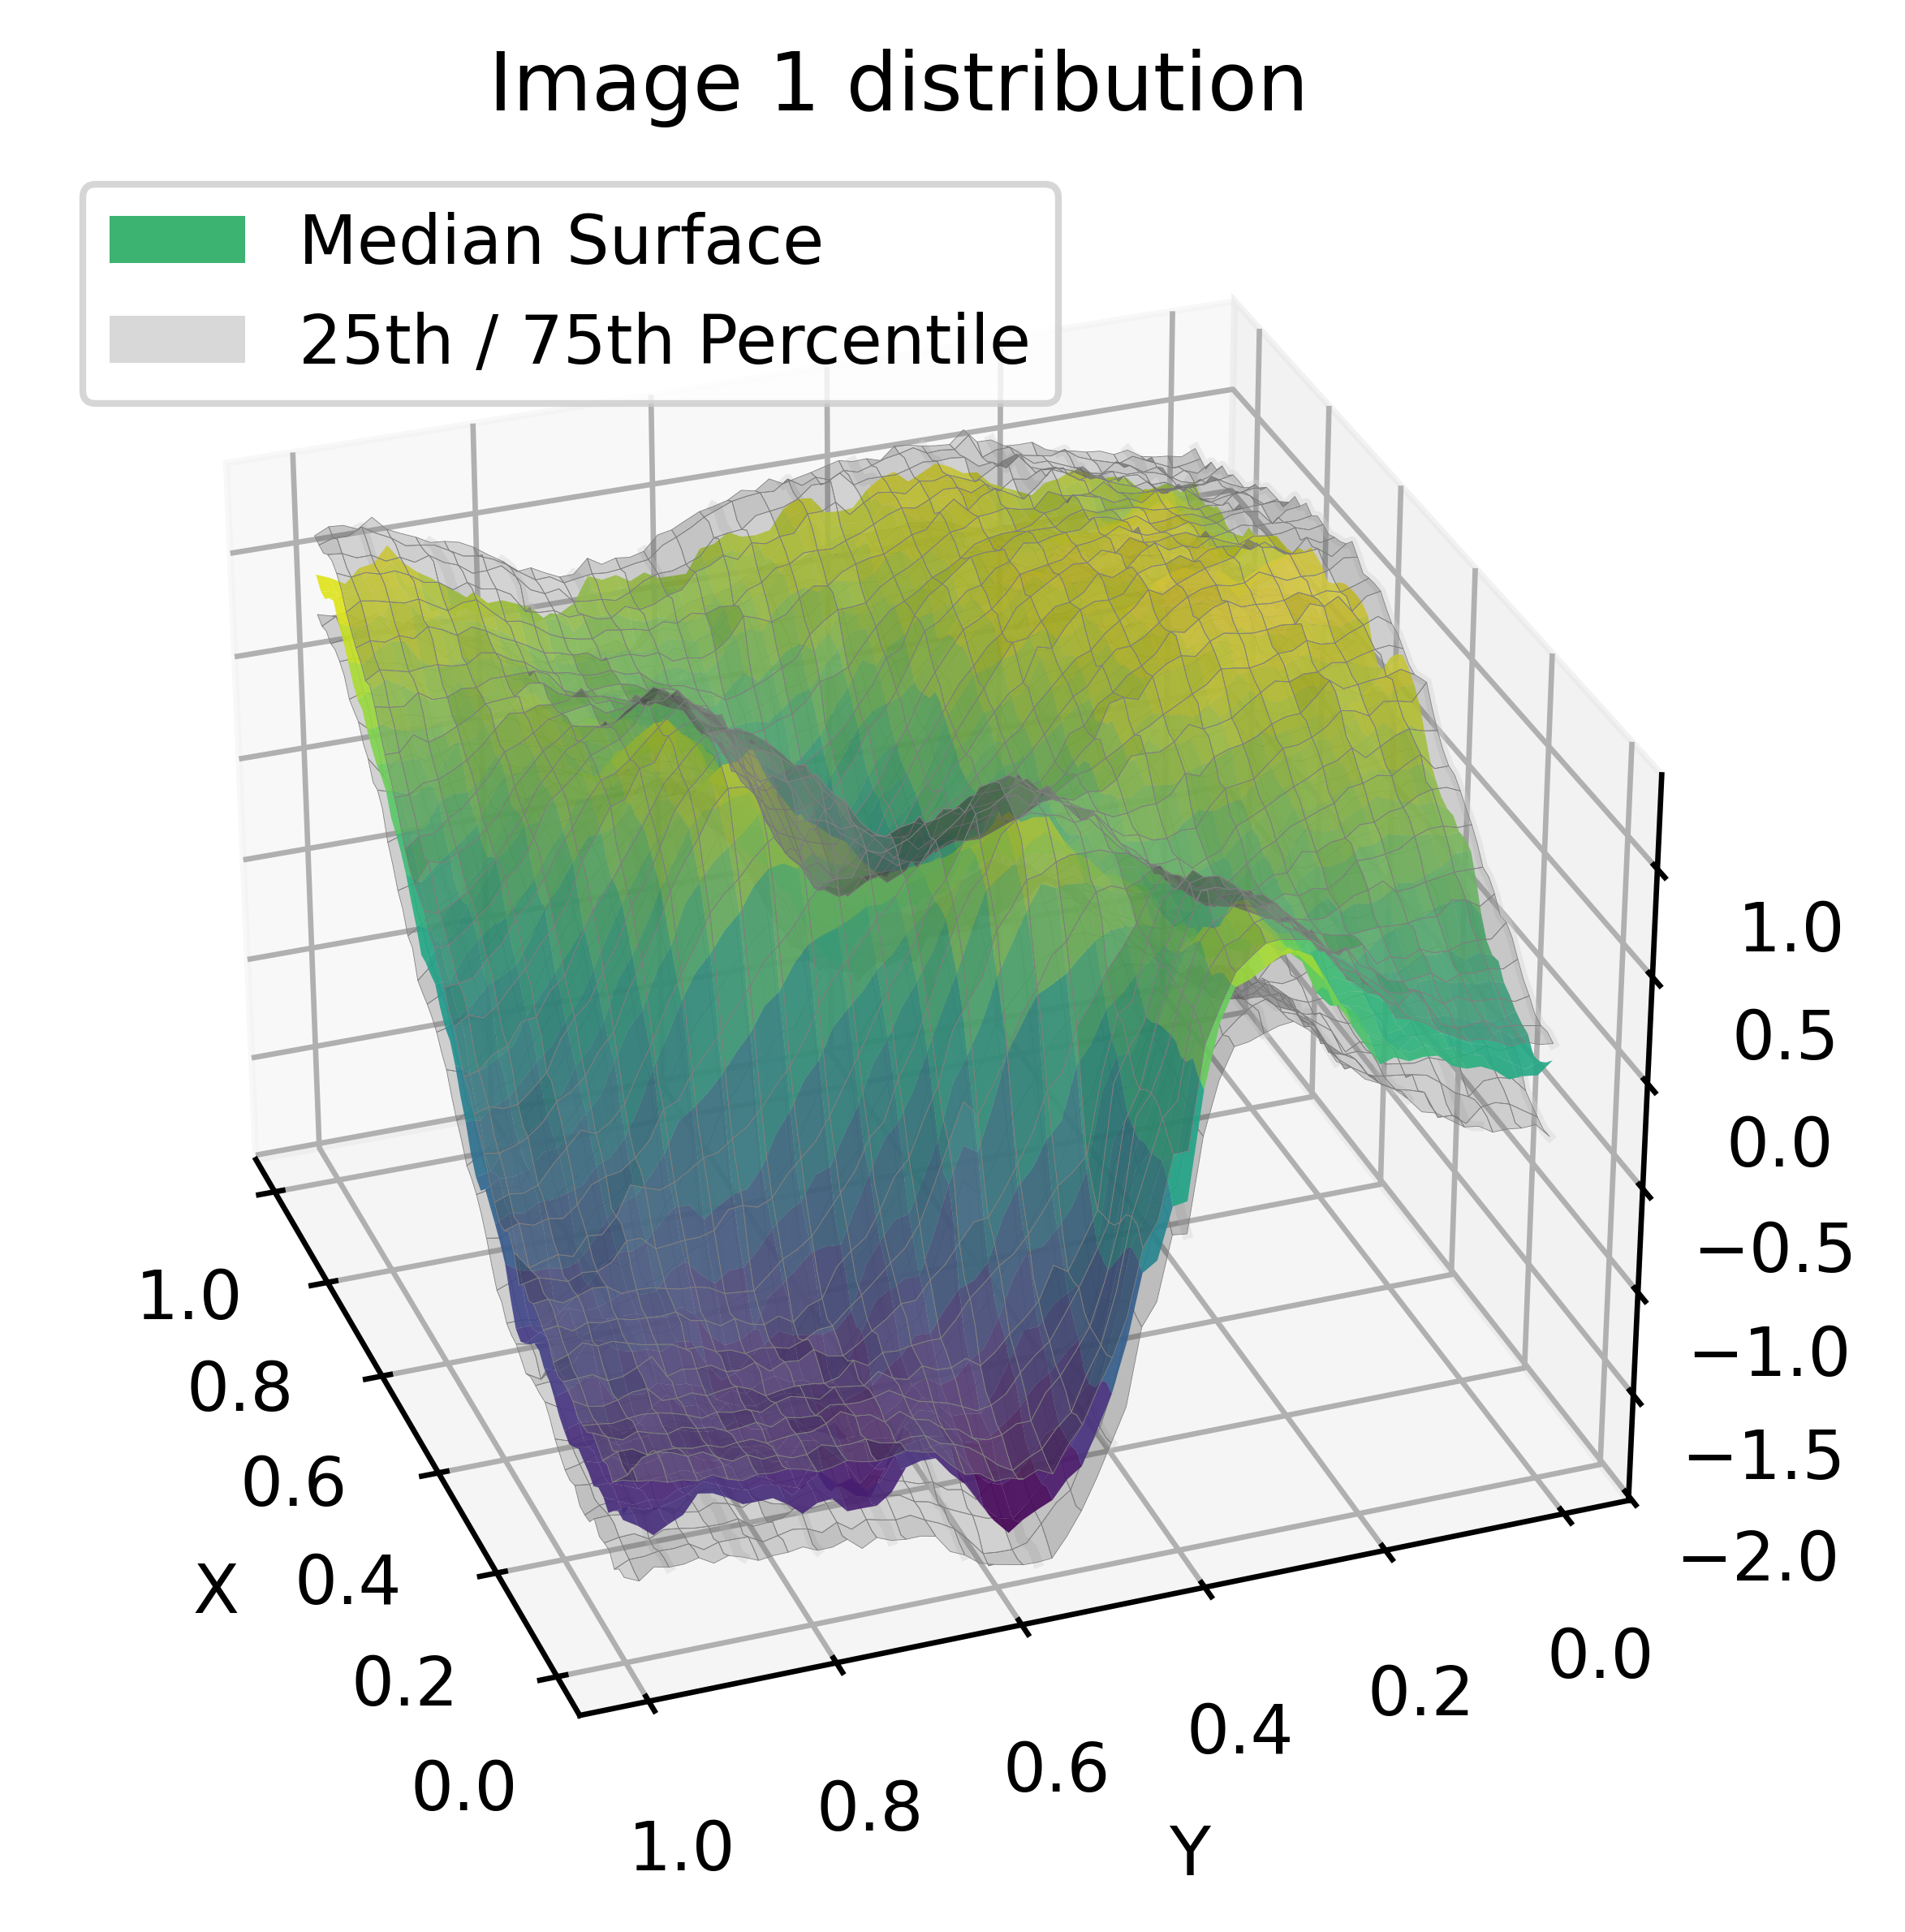

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulated data: 100 surfaces over a 50x50 grid
n_samples = 100
nx, ny = 64, 64
surfaces = np.random.randn(n_samples, nx, ny)  # shape (n, nx, ny)

# X, Y grid
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

# Compute quantiles
# median_surface = median_surface.data_matrix.squeeze()
q75 = upper_surface.squeeze()
q25 = lower_surface.squeeze()

# Plot
fig = plt.figure(figsize=(6, 4), dpi=600)
ax = fig.add_subplot(111, projection='3d')

# Plot median surface
ax.plot_surface(X, Y, median_surface, cmap='viridis', alpha=0.9, label='Median')

# Plot 25th percentile surface
ax.plot_surface(
    X, Y, q75, color='gray', 
    edgecolor='grey', 
    linewidth=.1,
    # edgealpha=.3,
    alpha=0.3
    )

# Plot 75th percentile surface
ax.plot_surface(
    X, 
    Y, 
    q25, 
    color='gray', 
    edgecolor='grey', 
    linewidth=.1,
    alpha=0.3)

# Optional: fill between surfaces using lines
for i in range(0, nx, 5):  # less dense lines for clarity
    ax.plot(X[i], Y[i], q25[i], color='lightgray', alpha=0.4)
    ax.plot(X[i], Y[i], q75[i], color='lightgray', alpha=0.4)

ax.set_title("Image 1 distribution")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='mediumseagreen', label='Median Surface'),
    Patch(facecolor='gray', alpha=0.3, label='25th / 75th Percentile')
]

ax.legend(handles=legend_elements, loc='upper left')

# ax.view_init(elev=15, azim=-100)   # shallow angle, from front-left
ax.view_init(azim=160)    # top-down



plt.tight_layout()
plt.show()


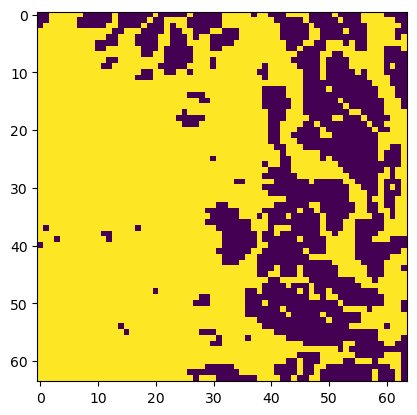

In [102]:
plt.imshow(np.logical_and(
    lower_surface.squeeze() < targets[0],
    upper_surface.squeeze() > targets[0])
)

In [103]:
np.logical_and(
    lower_surface.squeeze() < targets[0],
    upper_surface.squeeze() > targets[0]).sum() / hr_data_size**2

np.float64(0.6923828125)

Loop through each image and get target coverage

In [ ]:
global_noise = get_noise_from_cov_params_wSVD(global_cov_params, n_samples=100)

In [ ]:
global_coverage = []
imgspe_coverage = []

path_to_img_spec_noise = "/Users/hgoldwyn/Research/projects/SR_CNN/sr_cnn/real_data/torch/notebooks/covariance_subroutine/sample_data/from_kestrel/"

for i in range(targets.shape[0]):
    print(i)

    ## Get GLOBAL result
    g_samples = rescaled_noise + global_pred[i].ravel()[None, :]
    fd = FDataGrid(img_0_samples.reshape((-1, hr_data_size, hr_data_size)))

    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 50% deepest)
    n = len(fd)
    central_region_indices = np.argsort(-depths)[:n // 2]
    central_region = fd_g[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    global_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[0],
        upper_surface.squeeze() > targets[0]).sum() / hr_data_size**2
        )
    
    ## Get IMG-SPE result
    imgspe_samples = np.load(path_to_img_spec_noise + f"p2p5_img_{i}_noise_samples.npy") 
    
    fd = FDataGrid(imgspe_samples.reshape((-1, hr_data_size, hr_data_size)))

    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 50% deepest)
    n = len(fd)
    central_region_indices = np.argsort(-depths)[:n // 2]
    central_region = fd[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    imgspe_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[0],
        upper_surface.squeeze() > targets[0]).sum() / hr_data_size**2
        )


0
1
2
3
4
5


FileNotFoundError: [Errno 2] No such file or directory: '/Users/hgoldwyn/Research/projects/SR_CNN/sr_cnn/real_data/torch/notebooks/covariance_subroutine/sample_data/from_kestrel/p2p5_img_5_noise_samples.npy'

In [190]:
global_coverage

[np.float64(0.6923828125),
 np.float64(0.6923828125),
 np.float64(0.6923828125),
 np.float64(0.6923828125),
 np.float64(0.6923828125),
 np.float64(0.6923828125)]

# More samples

In [ ]:
def samples_for_plot(img, noise):
    _img_samples = noise + img.ravel()[None, :]
    _out = _img_samples.reshape((-1, hr_data_size, hr_data_size))
    return _out

In [41]:
global_cov_params.shape

(1089,)

In [42]:
global_img_0_noise_500 = get_noise_from_cov_params_wSVD(global_cov_params, n_samples=500)


In [46]:
global_img0_samples_500 = samples_for_plot(global_pred[0], global_img_0_noise_500)

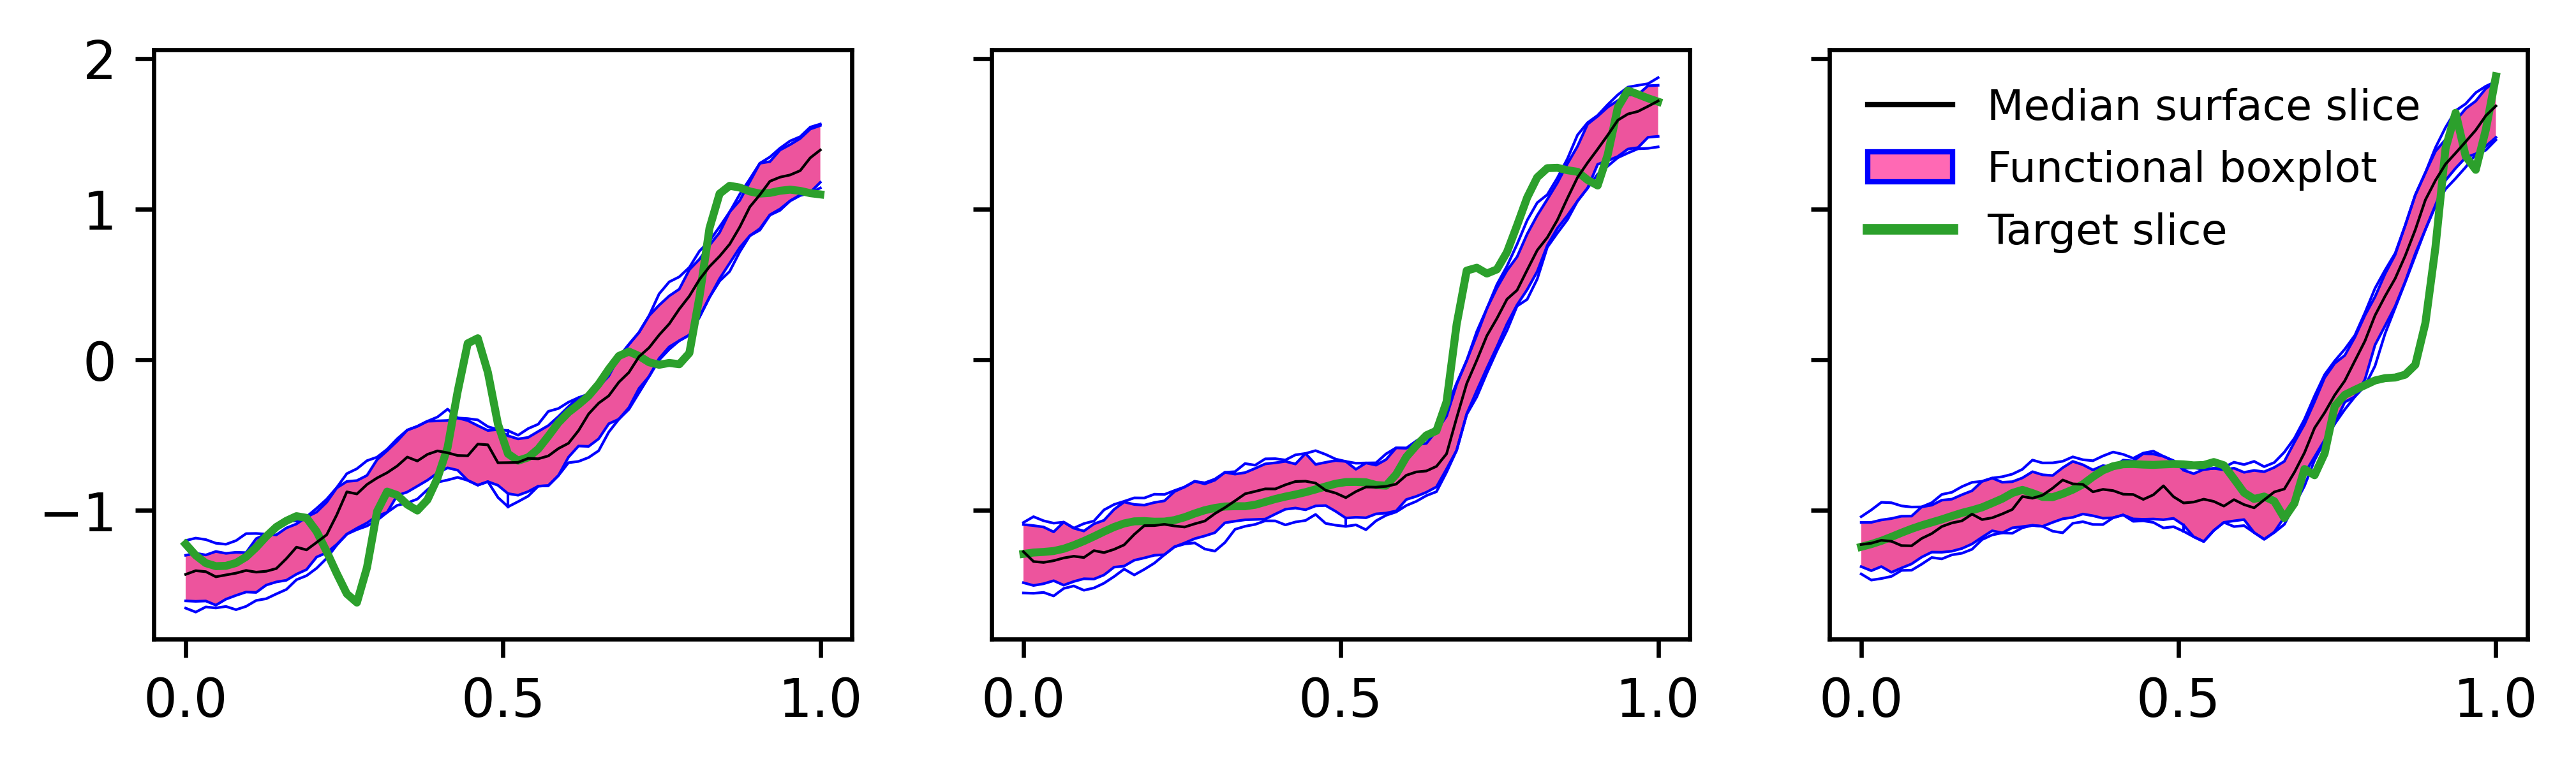

In [47]:

fig, axs = plt.subplots(1, 3, dpi=600, figsize=(8, 2), sharey=True)
# fig, axs = plt.subplots(3, 1, dpi=600, figsize=(4, 8), sharey=True, sharex=True)

_img_idx = 0
_img_samples = global_img0_samples_500

sliced_fd_0 = FDataGrid(_img_samples[:, 0, :])
boxplot = Boxplot(sliced_fd_0, axes=axs[0])
boxplot.plot()

sliced_fd_1 = FDataGrid(_img_samples[:, 31, :])
boxplot = Boxplot(sliced_fd_1, axes=axs[1])
boxplot.plot()

sliced_fd_2 = FDataGrid(_img_samples[:, 63, :])
boxplot = Boxplot(sliced_fd_2, axes=axs[2])
boxplot.plot()

for ax in axs:
    for line in ax.get_lines():
        line.set_linewidth(.5)  # set your desired linewidth

fig.canvas.draw()  # update the figure if you're in an interactive session

axs[0].plot(np.linspace(0, 1, 64), targets[_img_idx, 0, :], color='C2', zorder=4)
axs[1].plot(np.linspace(0, 1, 64), targets[_img_idx, 31, :], color='C2', zorder=4)
axs[2].plot(np.linspace(0, 1, 64), targets[_img_idx, 63, :], color='C2', zorder=4, label='target')

## ~~~ Legend ~~~
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

line_legend = Line2D([0], [0], color='C2', linewidth=2, label='Target slice')

# Patch: pink fill, blue top & bottom borders (emulated via lines in legend)
# We combine a filled Patch with a dummy label and then stack two lines
pink_patch = Patch(facecolor='#ff69b4', edgecolor='blue', label='Functional boxplot')

# You can make a compound legend item using dummy lines:
# blue_top = Line2D([0], [0], color='blue', linewidth=2)
# blue_bottom = Line2D([0], [0], color='blue', linewidth=2)

# Then manually create a custom legend
custom_handles = [
    Line2D([], [], color='black', linewidth=1, label='Median surface slice'),
    pink_patch,
    line_legend,
]

axs[2].legend(handles=custom_handles, loc='upper left', fontsize=8, frameon=False)


In [30]:
test_p2p5_cov_params.shape

(257, 1089)

In [31]:
p2p5_img_0_noise_500 = get_noise_from_cov_params_wSVD(test_p2p5_cov_params[0], n_samples=500)


In [32]:
def samples_for_plot(img, noise):
    _img_samples = noise + img.ravel()[None, :]
    _out = _img_samples.reshape((-1, hr_data_size, hr_data_size))
    return _out

In [33]:
p2p5_pred.shape

(257, 64, 64)

In [34]:
p2p5_img0_samples_500 = samples_for_plot(p2p5_pred[0], p2p5_img_0_noise_500)

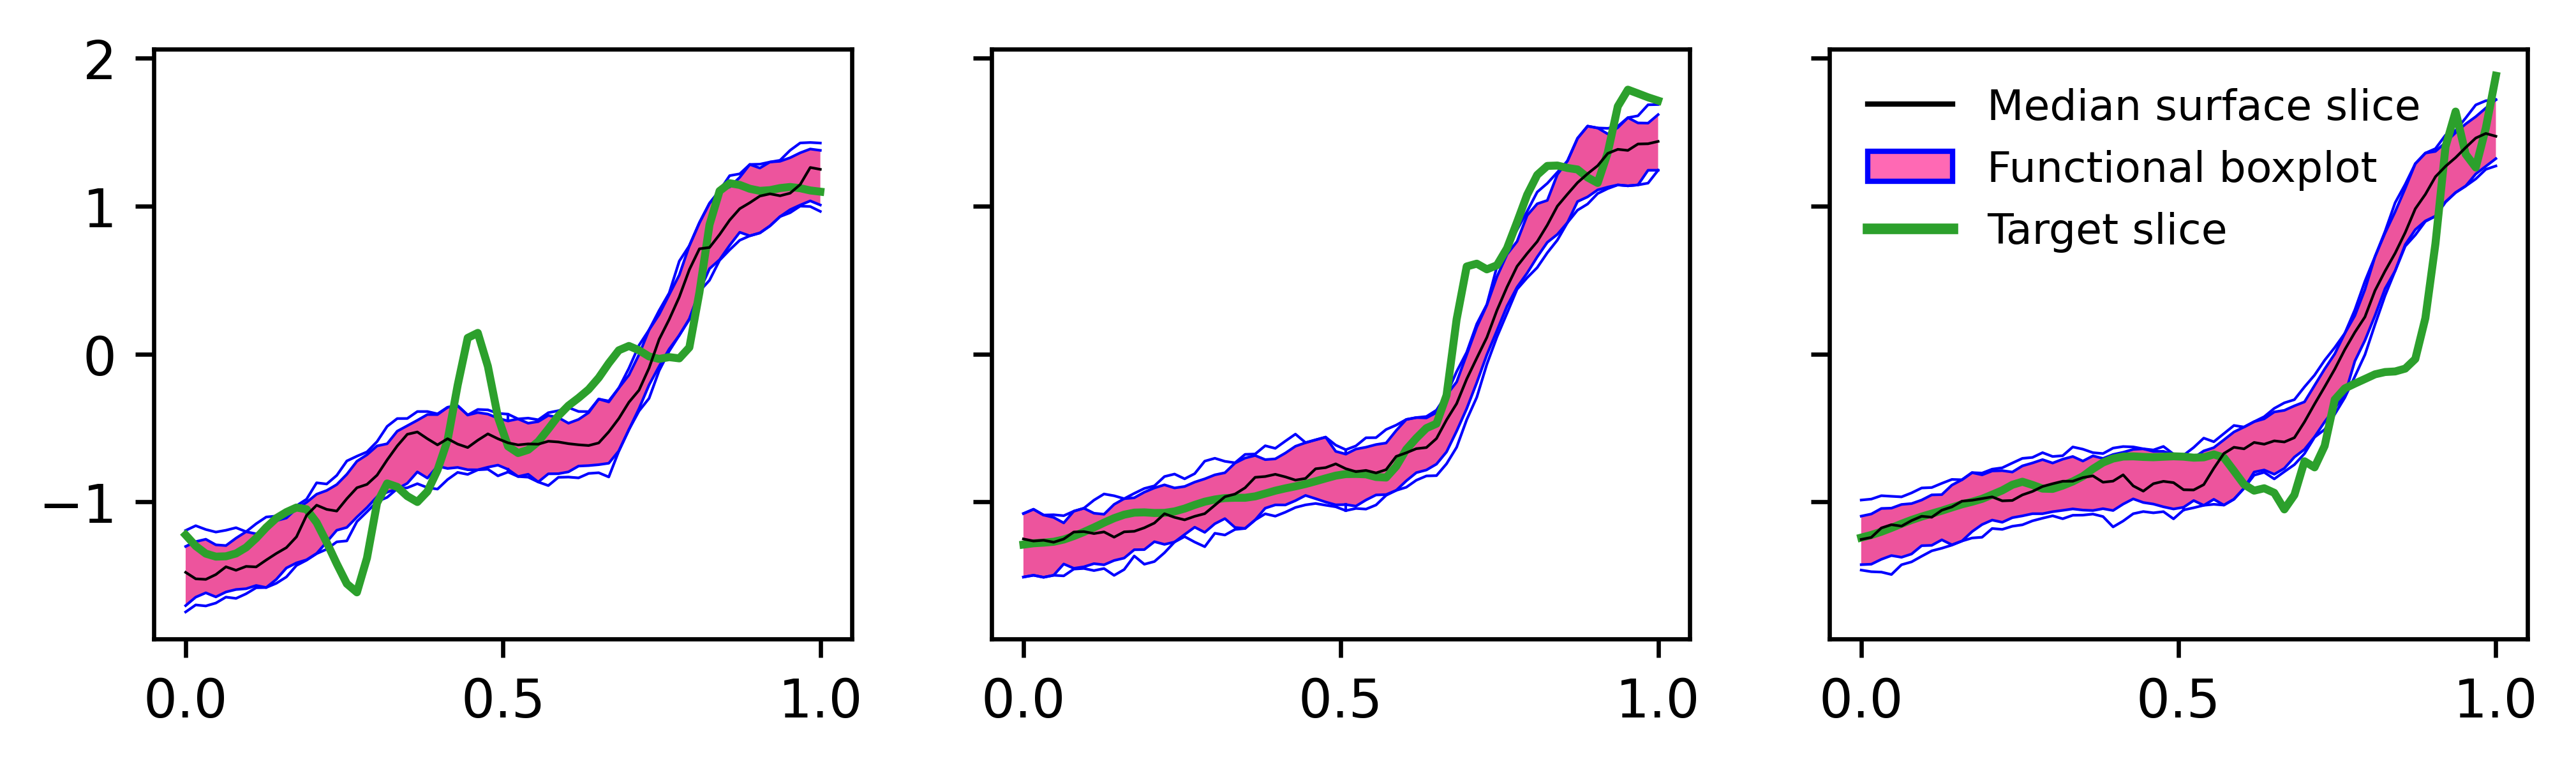

In [40]:

fig, axs = plt.subplots(1, 3, dpi=600, figsize=(8, 2), sharey=True)
# fig, axs = plt.subplots(3, 1, dpi=600, figsize=(4, 8), sharey=True, sharex=True)

_img_idx = 0
_img_samples = p2p5_img0_samples_500

sliced_fd_0 = FDataGrid(_img_samples[:, 0, :])
boxplot = Boxplot(sliced_fd_0, axes=axs[0])
boxplot.plot()

sliced_fd_1 = FDataGrid(_img_samples[:, 31, :])
boxplot = Boxplot(sliced_fd_1, axes=axs[1])
boxplot.plot()

sliced_fd_2 = FDataGrid(_img_samples[:, 63, :])
boxplot = Boxplot(sliced_fd_2, axes=axs[2])
boxplot.plot()

for ax in axs:
    for line in ax.get_lines():
        line.set_linewidth(.5)  # set your desired linewidth

fig.canvas.draw()  # update the figure if you're in an interactive session

axs[0].plot(np.linspace(0, 1, 64), targets[_img_idx, 0, :], color='C2', zorder=4)
axs[1].plot(np.linspace(0, 1, 64), targets[_img_idx, 31, :], color='C2', zorder=4)
axs[2].plot(np.linspace(0, 1, 64), targets[_img_idx, 63, :], color='C2', zorder=4, label='target')

## ~~~ Legend ~~~
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

line_legend = Line2D([0], [0], color='C2', linewidth=2, label='Target slice')

# Patch: pink fill, blue top & bottom borders (emulated via lines in legend)
# We combine a filled Patch with a dummy label and then stack two lines
pink_patch = Patch(facecolor='#ff69b4', edgecolor='blue', label='Functional boxplot')

# You can make a compound legend item using dummy lines:
# blue_top = Line2D([0], [0], color='blue', linewidth=2)
# blue_bottom = Line2D([0], [0], color='blue', linewidth=2)

# Then manually create a custom legend
custom_handles = [
    Line2D([], [], color='black', linewidth=1, label='Median surface slice'),
    pink_patch,
    line_legend,
]

axs[2].legend(handles=custom_handles, loc='upper left', fontsize=8, frameon=False)


In [48]:
from skfda.exploratory.depth import ModifiedBandDepth

# Create the depth object
depth = ModifiedBandDepth()

In [49]:
global_50_coverage = []
p2p5_50_coverage = []

path_to_img_spec_noise = "/Users/hgoldwyn/Research/projects/SR_CNN/sr_cnn/real_data/torch/notebooks/covariance_subroutine/sample_data/from_kestrel/"

for i in range(targets.shape[0]):
    print(i)

    #### Get GLOBAL result
    ## resample noise
    # g_noise = get_noise_from_cov_params_wSVD(global_u, global_s, n_samples=100)
    
    # g_samples = g_noise + global_pred[i].ravel()[None, :]
    g_samples = global_img0_samples_500
    
    ## Compute surfaces
    fd = FDataGrid(g_samples.reshape((-1, hr_data_size, hr_data_size)))
    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 50% deepest)
    n = len(fd)
    central_region_indices = np.argsort(-depths)[:n // 2]
    central_region = fd[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    global_50_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[i],
        upper_surface.squeeze() > targets[i]).sum() / hr_data_size**2
        )
    
    ## Get IMG-SPE result
    # is_noise = np.load(path_to_img_spec_noise + f"p2p5_img_{599+i}_noise_samples.npy") 
    # is_samples = p2p5_pred[i].ravel()[None, :] + is_noise
    is_samples = p2p5_img0_samples_500
    
    fd = FDataGrid(is_samples.reshape((-1, hr_data_size, hr_data_size)))

    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 50% deepest)
    n = len(fd)
    central_region_indices = np.argsort(-depths)[:n // 2]
    central_region = fd[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    p2p5_50_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[i],
        upper_surface.squeeze() > targets[i]).sum() / hr_data_size**2
        )
    
    if i == 10:
        break


0
1
2
3
4
5


KeyboardInterrupt: 

In [50]:
global_50_coverage

[np.float64(0.767822265625),
 np.float64(0.57421875),
 np.float64(0.32373046875),
 np.float64(0.20947265625),
 np.float64(0.238037109375)]

In [51]:
p2p5_50_coverage

[np.float64(0.7509765625),
 np.float64(0.62109375),
 np.float64(0.3818359375),
 np.float64(0.209716796875),
 np.float64(0.263671875)]